In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utils

In [2]:
def load_data():
    """
    Load the MNIST dataset. Reads the training and testing files and create matrices.
    :Expected return:
    train_data:the matrix with the training data
    test_data: the matrix with the data that will be used for testing
    y_train: the matrix consisting of one 
                        hot vectors on each row(ground truth for training)
    y_test: the matrix consisting of one
                        hot vectors on each row(ground truth for testing)
    """
    
    #load the train files
    df = None
    
    y_train = []

    for i in range( 10 ):
        tmp = pd.read_csv( 'data/mnist/train%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
        
        for j in range( tmp.shape[0] ):
            y_train.append( hot_vector )
        #concatenate dataframes by rows    
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    train_data = df.values
    y_train = np.array( y_train )
    
    #load test files
    df = None
    
    y_test = []

    for i in range( 10 ):
        tmp = pd.read_csv( 'data/mnist/test%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
        
        for j in range( tmp.shape[0] ):
            y_test.append( hot_vector )
        #concatenate dataframes by rows    
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    test_data = df.values
    y_test = np.array( y_test )
    
    return train_data, test_data, y_train, y_test

In [3]:
#use by default ax=1, when the array is 2D
#use ax=0 when the array is 1D
def softmax( x, ax=1 ):

    m = np.max( x, axis=ax, keepdims=True )#max per row
    p = np.exp( x - m )
    return ( p / np.sum(p,axis=ax,keepdims=True) )

In [13]:
class oneLayerMLP:
    
    def __init__(self, hiddenUnits , activationFunction):
        self.M = hiddenUnits
        self.h , self.hDeriv = self.getFunctions(activationFunction)
    
    def train(self,X,t,l,learningRate,batchSize,K,epochs):
        self.X =  np.hstack(( np.ones((X.shape[0],1)) , X ))    #adding the bias unit
        self.t = t
        self.l = l
        self.batchSize = batchSize
        self.K = K
#         self.w1 = np.ones((self.M,self.X.shape[1]))
#         self.w2 = np.ones((K,self.M+1)) 
        self.w1 = np.random.uniform( -np.sqrt(2/self.M) ,np.sqrt(2/self.M)  , (self.M,self.X.shape[1])) 
        self.w2 = np.random.uniform(-np.sqrt(2/K)  ,np.sqrt(2/K)  , (K,self.M+1)) 
        self.epochs = epochs
        self.costs = []
        
        batchesList = self.createMiniBatches()

        for e in range(epochs):
            epochCost = []
            for batchX , batchT in batchesList:
                a , dW1 , dW2 = self.SGD(batchX,batchT,learningRate)
                self.w1 =self.w1 + learningRate*dW1
                self.w2 = self.w2 + learningRate*dW2
                epochCost.append(a)
            self.costs.append( sum(epochCost)/self.batchSize )
    
    def SGD(self,batchX,batchT,learningRate):
        z,y = self.predict(batchX,addBias = False)
        Error = np.sum(np.log(y)*batchT) - (self.l/2) * ( np.sum( np.square( self.w1 ) ) -  np.sum( np.square( self.w2 ) ))    
        loss = (batchT - y)
        dW1 = ( loss.dot(self.w2[:,1:]) * self.hDeriv(batchX.dot(self.w1.T)) ).T.dot(batchX)  - self.l*self.w1
        dW2 = loss.T.dot(z) - self.l*self.w2
        
        return Error , dW1 ,dW2
    
    def predict(self,batchX , addBias=True ):
        if addBias:
            batchX =  np.hstack(( np.ones((batchX.shape[0],1)) , batchX ))  

        z = self.h( batchX.dot(self.w1.T))
        z = np.hstack(( np.ones((z.shape[0],1)) , z ))    #adding the bias unit
        y = softmax(z.dot(self.w2.T))

        return z,y
    
    def getFunctions(self,activationFunction):
        if activationFunction=="softplus":
            return lambda x: np.log(1+np.exp(x)) , lambda x: 1/(1+np.exp(-x))
        elif activationFunction=="tanh": 
            return lambda x: (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)) , lambda x: 1 - ((np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)))**2        
        elif activationFunction=="cos":
            return lambda x: np.cos(x) , lambda x: -np.sin(x)       
        else:
            print("Wrong code")
            return lambda x: 0  
        
        
    def createMiniBatches(self):
        stacked = np.hstack((self.X , self.t ))
#         np.random.shuffle(stacked)  
        batchesList = []
        i=0
        while i<stacked.shape[0]:
            if (i+self.batchSize<stacked.shape[0]):
                batchesList.append(stacked[i:i+self.batchSize])
            else:
                batchesList.append( stacked[i:])
                
            i+=self.batchSize
        
        batchesList = [ [ batch[:,:-self.K] , batch[:,-self.K:] ]  for batch in batchesList  ]
        return batchesList
    
    
    def gradcheck_softmax(self):

        epsilon = 1e-6

        _list = np.random.randint(X.shape[0], size=5)
        x_sample = np.array(self.X[_list, 0:100])
        t_sample = np.array(self.t[_list, 0:100])
        Ew, dW1 , dW2 = self.SGD(x_sample, t_sample, self.l)
        num_dW1 = np.zeros(dW1.shape)
        num_dW2 = np.zeros(dW2.shape)
        old_W1 = np.copy(self.w1)
        old_W2 = np.copy(self.w2)

        # Compute all numerical gradient estimates and store them in
        # the matrix numericalGrad
        for k in range(num_dW1.shape[0]):
            for d in range(num_dW1.shape[1]):
                #add epsilon to the w[k,d]
                self.w1 = np.copy(old_W1)
                self.w1[k, d] += epsilon
                e_plus, _ , _ = self.SGD(x_sample, t_sample, self.l)

                #subtract epsilon to the w[k,d]
                self.w1 = np.copy(old_W1)
                self.w1[k, d] -= epsilon
                e_minus, _ , _ = self.SGD(x_sample, t_sample, self.l)

                #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
                num_dW1[k, d] = (e_plus - e_minus) / (2 * epsilon)
                            
        self.w1 = np.copy(old_W1)
        for k in range(num_dW2.shape[0]):
            for d in range(num_dW2.shape[1]):

                #add epsilon to the w[k,d]
                self.w2 = np.copy(old_W2)
                self.w2[k, d] += epsilon
                e_plus, _ , _ = self.SGD(x_sample, t_sample, self.l)

                #subtract epsilon to the w[k,d]
                self.w2 = np.copy(old_W2)
                self.w2[k, d] -= epsilon
                e_minus, _ , _ = self.SGD(x_sample, t_sample, self.l)

                #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
                num_dW2[k, d] = (e_plus - e_minus) / (2 * epsilon)
            
            self.w2 = np.copy(old_W2)
        return ( dW1, num_dW1 , dW2 , num_dW2 )

In [14]:
p = oneLayerMLP(10,"cos")
X = np.array([[1,2,3],[4,5,6],[7,8,9],[1,2,3],[4,6,6],[7,8,9] ,[1,2,3],[4,7,6],[7,8,9]   ])
t = np.array([[0,1],[0,1],[1,0],[0,1],[0,1],[1,0],[0,1],[0,1],[1,0],])
p.train(X,t,0.1,0.001,3,2,1)
p.costs

[-5.407357449065413]

In [15]:
res = p.gradcheck_softmax()


In [19]:
X_train, X_test, y_train, y_test = load_data()
X_train = X_train.astype(float)/255
X_test = X_test.astype(float)/255

In [28]:
p = oneLayerMLP(200,"tanh")
X = X_train
t =y_train
p.train(X,t,0.1,0.001,200,10,20)


In [29]:
p.costs

[-275.3349161568674,
 -165.9352843751199,
 -116.97552200783475,
 -95.1927983876926,
 -80.8136538581284,
 -76.10773852503677,
 -77.54116953075827,
 -76.6699208531895,
 -73.33126050422004,
 -69.96731453033057,
 -66.38705916053249,
 -62.315192534935974,
 -58.179950180719935,
 -54.387042077534026,
 -52.65625224196683,
 -50.2650763235407,
 -48.16099974899589,
 -46.479534997949465,
 -45.31242266874721,
 -43.37000618654126]

In [30]:
_ , pred = p.predict(X_test,addBias=True)

In [31]:
np.mean( np.argmax(pred,1) == np.argmax(y_test,1) )

0.3597

<ipython-input-238-ec6a204a4295>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')


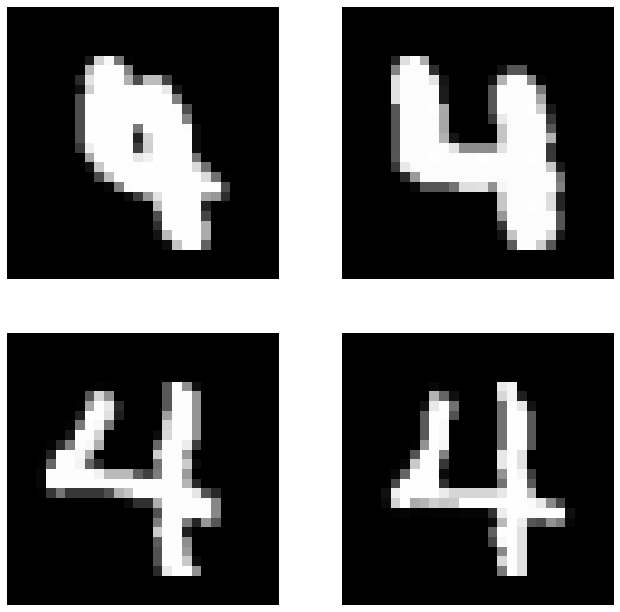

In [238]:
# plot 5 random images from the training set
n = 5
sqrt_n = int( n**0.5 )
samples = np.random.randint(X_train.shape[0], size=n)
samples = [5000,5001,5002,5003]
plt.figure( figsize=(11,11) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_test[i].reshape(28,28), cmap='gray'  )

plt.show()